In [1]:
import platform

global systemDivide
global RecursionBorder
RecursionBorder = 1_0

if platform.platform().split('-')[0] == 'macOS':
    systemDivide = '/'
else:
    systemDivide = '\\'

import sys
import threading

threading.stack_size(2**27)
sys.setrecursionlimit(10 ** 5)

import matplotlib.pylab as plt

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn.model_selection import ParameterGrid
from sklearn import linear_model

In [2]:
pairName = 'CHFJPY.csv'

inpData = pd.read_csv(f"testData{systemDivide}{pairName}", index_col=1)
# Какие колонки нужны для работы
columns = ['open', 'high', 'low', 'close']
inpData = inpData[columns]
inpData.index = pd.to_datetime(inpData.index)

In [3]:
def create_strategy_config(params):
    """
    Создает удобную сетку для дальнейших расчетов
    :param params: начальные init параметры
    :return: словарь из параметров использующийся везде
    """
    capital = 20_000
    slippage = 2
    retParams = {
        # Капитал
        'capital': capital,
        'slippage': slippage,
        # Можно использовать для стоп лоссов и тейков с учетом слипэджа
        'slippagePerCapital': slippage / capital,
        # То какой размах мы будем брать для построения полос Боллинджера. Это и есть X Threshold из файла Евгения
        'yThreshold': round(params['yThreshold'] / 100, 2),
        # Период за который мы строим малую скользяшку
        'rollingMean': None,
        # Период за который мы строим большую скользяшку
        'fatRollingMean': None,
        # Временной барьер, Максимальное время сколько мы можем держать позицию
        'timeBarrier': None,
        # Параметр для определения того что данные MeanReversion/TrendFollowing
        # Используется в VRratio тестах для открытия/удержания позиции
        'varianceRatioFilter': params['varianceRatioFilter'],
        'reverseVarianceRatioFilter': params['reverseVarianceRatioFilter'],
        # Сколько времени мы не торгуем после срабатывания стоп лосса
        'restAfterLoss': params['restAfterLoss'],
        # Сколько времени мы не торгуем после закрытия позиции о большую скользяшку
        'restAfterFatProfit' : params['restAfterFatProfit'],
        # Процент стоп лосса
        'stopLossStdMultiplier': round(params['stopLossStdMultiplier'] / 100, 3),
        # Процент тэйк профита
        'takeProfitStdMultiplier': round(params['takeProfitStdMultiplier'] / 100, 3),
        # Нужно чтобы пересчитывать VR границы в автоматическом режиме
        'varianceRatioCarreteParameter': params['varianceRatioCarreteParameter'],
        # Тот период за который мы будем считать Variance Ratio. Те ставя тут к примеру 1500, мы должны будем передавать в функцию
        # VR Ratio 1500 точек данных. Сейчас этот гипермараметр связан с гиперпараметров периода малой скользяшки
        'varianceLookBack': None,
        # Чему будет равен временной лаг Q; Q = varianceLookBack // PARAM + 1
        'varianceRatioCarrete': None,
        # Параметр по которому мы будем искать период полураспада
        'scanHalfTime': int(params['scanHalfTime']),
        #
        'halfToFat': params['halfToFat'],
        #
        'halfToLight': params['halfToLight'],
        #
        'halfToTime': params['halfToTime'],

    }
    return retParams

# grid_params = {
#     # Оптимизировать !!!
#     'yThreshold': [300, 200],
#     # Оптимизировать !
#     'varianceRatioFilter': [0.9],
#     # Оптимизировать !
#     'reverseVarianceRatioFilter': [0.95],
#     # Оптимизировать !!
#     'restAfterLoss': [90],
#     # Оптимизировать !
#     'restAfterFatProfit' : [250],
#     # Оптимизировать !!
#     'stopLossStdMultiplier': [1620],
#     # Оптимизировать !
#     'takeProfitStdMultiplier': [920],
#     # Оптимизировать !!
#     'varianceRatioCarreteParameter': [10],
#     # Оптимизировать !!!
#     'scanHalfTime': [1500],
#     # Оптимизировать 0!
#     'halfToFat': [3.0],
#     # Оптимизировать 0!
#     'halfToLight': [1.0],
#     # Оптимизировать 0!
#     'halfToTime': [1.0],
#     }

# Ivan test
grid_params = {
    # Оптимизировать !!!
    'yThreshold': [300],
    # Оптимизировать !
    'varianceRatioFilter': [1.0],
    'reverseVarianceRatioFilter': [1.0],
    # Оптимизировать !!
    'restAfterLoss': [100],
    # Оптимизировать !
    'restAfterFatProfit' : [0],
    # Оптимизировать !!
    'stopLossStdMultiplier': [120_00],
    # Оптимизировать !
    'takeProfitStdMultiplier': [5000],
    # Оптимизировать !!
    'varianceRatioCarreteParameter': [20],
    # Оптимизировать !!!
    'scanHalfTime': [500],
    # Оптимизировать 0!
    'halfToFat': [2.5],
    # Оптимизировать 0!
    'halfToLight': [1],
    # Оптимизировать 0!
    'halfToTime': [3],
    }

grid_params = ParameterGrid(grid_params)
grid_params = pd.DataFrame(grid_params).sample(frac=1, random_state=9).reset_index(drop=True)
create_strategy_config(grid_params.iloc[0])

{'capital': 20000,
 'slippage': 2,
 'slippagePerCapital': 0.0001,
 'yThreshold': 3.0,
 'rollingMean': None,
 'fatRollingMean': None,
 'timeBarrier': None,
 'varianceRatioFilter': 1.0,
 'reverseVarianceRatioFilter': 1.0,
 'restAfterLoss': 100.0,
 'restAfterFatProfit': 0.0,
 'stopLossStdMultiplier': 120.0,
 'takeProfitStdMultiplier': 50.0,
 'varianceRatioCarreteParameter': 20.0,
 'varianceLookBack': None,
 'varianceRatioCarrete': None,
 'scanHalfTime': 500,
 'halfToFat': 2.5,
 'halfToLight': 1.0,
 'halfToTime': 3.0}

In [4]:
def cook_data(df: pd.DataFrame, params) -> pd.DataFrame:
    """
    Подготавливает данные для дальнейшего рассчета стратегии.
    Передается на одну точку влева данных больше
    :param df: должен быть open, close, low, high
    :param params: список параметров из create_grid
    :return: данные с полосами Болинджера + логарифмы + возвраты
    """
    df['rollMean'] = df['open'].rolling(window=params['rollingMean']).mean()
    df['rollingStd'] = df['open'].rolling(window=params['rollingMean']).std()
    df['fatMean'] = df['open'].rolling(window=params['fatRollingMean']).mean()
    df['logOpenPrice'] = np.log(df['open'])
    df['retOpenPrice'] = df['logOpenPrice'].diff()
    return df.iloc[1:]

In [35]:
def get_half_time(openTuple: pd.Series) -> float:
    df_open = openTuple.to_frame()
    df_lag = df_open.shift(1)
    df_delta = df_open - df_lag
    linear_regression_model = linear_model.LinearRegression()
    df_delta = df_delta.values.reshape(len(df_delta), 1)
    df_lag = df_lag.values.reshape(len(df_lag), 1)
    linear_regression_model.fit(df_lag[1:], df_delta[1:])
    half_life = -np.log(2) / linear_regression_model.coef_.item()
    return half_life

def variance_ratio(logTuple: tuple, retTuple: tuple, params: dict) -> bool:
    """
    Функция для open. Здесь лаг q зависит только от гиперпараметра
    Возвращает значение variacne ratio. Необходимо для понимания того, можно ли открывать сделку
    :param logTuple: tuple из цен открытия включая проверяемую точку
    :param retTuple: tuple из цен открытия включая проверяемую точку
    :param params: список параметров из create_grid
    :return: Можно ли открывать сделку. Фактически является фильтром
    """
    buffer_size = len(retTuple)
    means = (1 / buffer_size) * np.sum(retTuple)
    # сдвиг во времени q
    m = params['varianceRatioCarrete'] * (buffer_size - params['varianceRatioCarrete'] + 1 ) * (1 - (params['varianceRatioCarrete'] / buffer_size))
    sigma_a = (1 / (buffer_size - 1)) * np.sum(np.square(np.subtract(retTuple, means)))
    subtract_returns = np.subtract(logTuple, np.roll(logTuple, params['varianceRatioCarrete']))[params['varianceRatioCarrete']:]
    _buff_ = np.sum(np.square(subtract_returns - params['varianceRatioCarrete'] * means))
    try:
        sigma_b = (1 / m) * _buff_
    except ZeroDivisionError:
        return False

    result = (sigma_b / sigma_a)
    if result < params['varianceRatioFilter']:
        return True
    else:
        return False

def reverse_variance_ratio(preComputed, params: dict, timeBorderCounter: int, VRstatement=False) -> bool:
    """
    Возвращает значение variacne ratio. Необходимо для понимания того, можно ли открывать сделку
    :param preComputed: Заранее просчитанные логарифмы и возвраты
    :param params: список параметров из create_grid
    :param timeBorderCounter: Штука показывающая сколько мы находимся в сделке
    :param VRstatement: Тип того для чего мы проверяем варианс рейшу, для входа в режим поиска
    False большой скользяшке, или True для возврата к малой скользяшке

    :return: Можно ли открывать сделку. Фактически является фильтром
    """
    retTuple = preComputed["retOpenPrice"]
    logTuple = preComputed["logOpenPrice"]
    if timeBorderCounter < params["varianceLookBack"]:
        buffer_size = len(retTuple)
        means = (1 / buffer_size) * np.sum(retTuple)
        # сдвиг во времени q
        m = timeBorderCounter * (buffer_size - timeBorderCounter + 1 ) * (1 - (timeBorderCounter / buffer_size))
        sigma_a = (1 / (buffer_size - 1)) * np.sum(np.square(np.subtract(retTuple, means)))
        subtract_returns = np.subtract(logTuple, np.roll(logTuple, timeBorderCounter))[timeBorderCounter:]
        _buff_ = np.sum(np.square(subtract_returns - timeBorderCounter * means))
        sigma_b = (1 / m) * _buff_
        result = (sigma_b / sigma_a)
        if not VRstatement:
            if result > params['reverseVarianceRatioFilter']:
                return True
            else:
                return False
        if VRstatement:
            if result < params['varianceRatioFilter']:
                return True
            else:
                return False
    else:
        return False

def calculate_max_drawdown(PNL_SERIES, dollars=True):
    """
    solution by Marco de Prado
    :param PNL_SERIES:
    :param dollars:
    :return:
    """
    dropout_df = PNL_SERIES.to_frame('pnl')
    dropout_df['hwm'] = dropout_df.expanding().max()
    df0 = dropout_df.groupby('hwm').min().reset_index()
    df0.columns = ['hwm', 'min']
    df0 = df0[df0['hwm'] > df0['min']]
    if dollars:
        dd = df0['hwm'] - df0['min']
    else:
        dd = df0['min'] / df0['hwm']

    return max(dd)

def open_position(position, dataFrame, params, reqCounter, preComputed):
    TRIGGER = False
    localParams = params.copy()
    openDict = {
        'typeOperation': None,
        'position': None,
        'openPrice': None,
        'openIndex': None,
        'stopLossBorder': None,
        'takeProfitBorder': None
    }
    if reqCounter >= RecursionBorder:
        return position

    # Получить время полураспада для генерации параметров сделки
    half_time = int(get_half_time(dataFrame.close[position-params['scanHalfTime']:position]))
    if (half_time > params['scanHalfTime']) or (half_time < 0):
        return open_position(position=position+1, dataFrame=dataFrame, params=params, reqCounter=reqCounter+1, preComputed=preComputed)

    localParams["rollingMean"] = int(half_time * params['halfToLight'])
    localParams["fatRollingMean"] = int(params['halfToFat'] * half_time)
    localParams["timeBarrier"] = int(half_time * params['halfToTime'])
    if localParams["timeBarrier"] <= 0:
        localParams["timeBarrier"] = 1

    localParams["varianceLookBack"] = int(half_time * params['halfToFat'])
    localParams["varianceRatioCarrete"] = int((half_time * params['halfToFat']) // params['varianceRatioCarreteParameter']) + 1
    # Считаем локальные барьеры открытия сделки
    bands_roll = dataFrame.open.iloc[position-half_time:position].rolling(localParams["rollingMean"])
    bands_mean = bands_roll.mean().iloc[-1]
    bands_std = bands_roll.std().iloc[-1]
    low_band = round(bands_mean - bands_std * params['yThreshold'],3)
    high_band = round(bands_mean + bands_std * params['yThreshold'],3)

    if (dataFrame.open[position] > low_band) and (dataFrame.low[position] < low_band):
        # Если это так, то убеждаемся что можем открыть сделку проводя тест
        # VR_RATIO (LOOKBACK={HYPERPARAMETER}, time_laq===q={HYPERPARAMETER})
        if variance_ratio(logTuple=preComputed["logTuple"][position - localParams['varianceLookBack']:position],
                      retTuple=preComputed["retTuple"][position - localParams['varianceLookBack']:position],params=localParams):
            # Формируем удобочитаемый тип return функции
            openDict['typeOperation'] = 'BUY'
            openDict['position'] = round(params['capital'] / low_band, 3)
            openDict['openPrice'] = low_band
            openDict['openIndex'] = position
            openDict['stopLossBorder'] = round(low_band - params['stopLossStdMultiplier'] * bands_std,3)
            openDict['takeProfitBorder'] = round(low_band + params['takeProfitStdMultiplier'] * bands_std,3)
            TRIGGER = True
            return {'openDict': openDict, 'params': localParams}

    elif (dataFrame.open[position] < high_band) and (dataFrame.high[position] > high_band):
        # Если это так, то убеждаемся что можем открыть сделку проводя тест
        # VR_RATIO (LOOKBACK={HYPERPARAMETER}, time_laq===q={HYPERPARAMETER})
        if variance_ratio(logTuple=preComputed["logTuple"][position - localParams['varianceLookBack']:position],
                      retTuple=preComputed["retTuple"][position - localParams['varianceLookBack']:position],params=localParams):
            # Формируем удобочитаемый тип return функции
            openDict['typeOperation'] = 'SELL'
            openDict['position'] = round(-1 * (params['capital'] / high_band), 3)
            openDict['openPrice'] = high_band
            openDict['openIndex'] = position
            openDict['stopLossBorder'] = round(high_band + params['stopLossStdMultiplier'] * bands_std,3)
            openDict['takeProfitBorder'] = round(high_band - params['takeProfitStdMultiplier'] * bands_std,3)
            TRIGGER = True
            return {'openDict': openDict, 'params': localParams}

    # В случае, если сделку открыть не получилось, переходим к следующей точке. Вывод - пока что сделку не получилось
    # В real-time это является аналогом ожидания до появления следующих данных и повторения проверки на открытие уже на них
    if not TRIGGER:
        return open_position(position=position+1, dataFrame=dataFrame, params=params, reqCounter=reqCounter+1, preComputed=preComputed)

def close_position(position, openDict, dataFrame, localParams, reqCounter, preComputed, borderCounter, indicatorVR):
    TRIGGER = False
    if reqCounter > RecursionBorder:
        return [position, localParams, borderCounter, indicatorVR, openDict]

    if borderCounter == localParams['timeBarrier']:
        return {'typeHolding': 'endPeriod', 'closePrice': dataFrame.open[position+1],
                        'closeIndex': position+1}

    elif openDict['typeOperation'] == 'BUY':
        # Стоп лосс условие
        if (dataFrame.open[position] > openDict['stopLossBorder']) and (dataFrame.low[position] < openDict['stopLossBorder']):
            return {'typeHolding': 'stopLoss', 'closePrice': openDict['stopLossBorder'],
                        'closeIndex': position}
        if dataFrame.open[position] < openDict['stopLossBorder']:
            return {'typeHolding': 'stopLoss', 'closePrice': dataFrame.open[position],
                        'closeIndex': position}
        # Smart mean crossing
        # Проверяем адекватное расположение между открытием и скользящей малой. Причина этого такая же как для open_position
        # Читай в чем суть - выше!
        elif (dataFrame.open[position] < preComputed["rollMean"][position]) and (not indicatorVR):
            # Проверяем что можно закрыть лонг о пересечение с малой скользящей
            if dataFrame.high[position] > preComputed["rollMean"][position]:
                # Проверяем можно ли продолжить удержание позиции. Делаем это через VariacneRatio за какой-то период
                # arrowIndex - params['varianceLookBack'], где varianceLookBack - гиперпараметр стратегии.
                # Временной лаг Q для VARIANCE_RATIO определяется как время что мы находимся в позиции
                # Если VarianceRatio показывает что данные стали TrendFollowing - мы меняем режим стратегии на попытку закерыться
                # О скользящее среднее за больший период. Так мы получим большую прибыль
                if preComputed["rollMean"][position] < preComputed["fatMean"][position]:
                    if reverse_variance_ratio(preComputed=preComputed,
                                      params=localParams, timeBorderCounter=borderCounter+1):
                        #   Local Trend Following recursion
                        return close_position(position=position+1, dataFrame=dataFrame, reqCounter=reqCounter+1,
                                              openDict=openDict, localParams=localParams, preComputed=preComputed,
                                              borderCounter=borderCounter+1, indicatorVR=True)

                    else:
                        # Если VR RATIO не показал возможность попытаться закрыться о большую скользяшку, то закрываемся
                        # о малую
                        return {'typeHolding': 'lightCross', 'closePrice': preComputed["rollMean"][position],
                                'closeIndex': position }
                        pass

                else:
                    # Может быть так, что скольщяшее среднее за больший период находится выше чем скользящее за малый период
                    # Если учесть что мы торгуем на тех инструментах что показывают большую склонность к meanReversion
                    # такая ситуцация говорит нам что нужно как можно скорей сбрасывать позицию.
                    return {'typeHolding': 'lightCrossEmergent', 'closePrice': preComputed["rollMean"][position],
                                'closeIndex': position}

        # Определяет режим работы в случае альтернативной стратегии на которую мы переключаеся в случае выполнения каких-то условий
        if indicatorVR:
            # Аналогично тому что было раньше
            if dataFrame.open[position] < preComputed["fatMean"][position]:
                # Аналогично тому что было раньше
                if dataFrame.high[position] > preComputed["fatMean"][position]:
                    return {'typeHolding': 'fatExtraProfit', 'closePrice': preComputed["fatMean"][position],
                            'closeIndex': position}
                # Даем возможность переключить режим стратегии снова на нулевой. Делаем это если данные снова начали показывать
                # склонность к meanReversion
                # if variance_ratio(logTuple=dataTuple["logTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],
                #       retTuple=dataTuple["retTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
                #     indicatorVR = False
                # ANOTHER LOGIC
            if not reverse_variance_ratio(preComputed=preComputed,
                                  params=localParams, timeBorderCounter=borderCounter+1, VRstatement=True):
                    #   Local Trend Following recursion
                return close_position(position=position+1, dataFrame=dataFrame, reqCounter=reqCounter+1,
                                          openDict=openDict, localParams=localParams, preComputed=preComputed,
                                          borderCounter=borderCounter+1, indicatorVR=False)


    elif openDict['typeOperation'] == 'SELL':
        # Стоп лосс условие
        if (dataFrame.open[position] < openDict['stopLossBorder']) and (dataFrame.high[position] > openDict['stopLossBorder']):
            return {'typeHolding': 'stopLoss', 'closePrice': openDict['stopLossBorder'],
                        'closeIndex': position}
        if dataFrame.open[position] > openDict['stopLossBorder']:
            return {'typeHolding': 'stopLoss', 'closePrice': dataFrame.open[position],
                        'closeIndex': position}
        # Smart mean crossing
        # Проверяем адекватное расположение между открытием и скользящей малой. Причина этого такая же как для open_position
        # Читай в чем суть - выше!

        elif (dataFrame.open[position] > preComputed["rollMean"][position]) and (not indicatorVR):
            # Проверяем что можно закрыть лонг о пересечение с малой скользящей
            if dataFrame.low[position] < preComputed["rollMean"][position]:
                # Проверяем можно ли продолжить удержание позиции. Делаем это через VariacneRatio за какой-то период
                # arrowIndex - params['varianceLookBack'], где varianceLookBack - гиперпараметр стратегии.
                # Временной лаг Q для VARIANCE_RATIO определяется как время что мы находимся в позиции
                # Если VarianceRatio показывает что данные стали TrendFollowing - мы меняем режим стратегии на попытку закерыться
                # О скользящее среднее за больший период. Так мы получим большую прибыль
                if preComputed["rollMean"][position] > preComputed["fatMean"][position]:
                    if reverse_variance_ratio(preComputed=preComputed,
                                      params=localParams, timeBorderCounter=borderCounter+1, VRstatement=False):
                        #   Local Trend Following recursion
                        return close_position(position=position+1, dataFrame=dataFrame, reqCounter=reqCounter+1,
                                              openDict=openDict, localParams=localParams, preComputed=preComputed,
                                              borderCounter=borderCounter+1, indicatorVR=True)

                    else:
                        # Если VR RATIO не показал возможность попытаться закрыться о большую скользяшку, то закрываемся
                        # о малую
                        return {'typeHolding': 'lightCross', 'closePrice': preComputed["rollMean"][position],
                                'closeIndex': position }
                        pass

                else:
                    # Может быть так, что скольщяшее среднее за больший период находится выше чем скользящее за малый период
                    # Если учесть что мы торгуем на тех инструментах что показывают большую склонность к meanReversion
                    # такая ситуцация говорит нам что нужно как можно скорей сбрасывать позицию.
                    return {'typeHolding': 'lightCrossEmergent', 'closePrice': preComputed["rollMean"][position],
                                'closeIndex': position}

        # Определяет режим работы в случае альтернативной стратегии на которую мы переключаеся в случае выполнения каких-то условий
        if indicatorVR:
            # Аналогично тому что было раньше
            if dataFrame.open[position] > preComputed["fatMean"][position]:
                # Аналогично тому что было раньше
                if dataFrame.low[position] < preComputed["fatMean"][position]:
                    return {'typeHolding': 'fatExtraProfit', 'closePrice': preComputed["fatMean"][position],
                            'closeIndex': position}
                # Даем возможность переключить режим стратегии снова на нулевой. Делаем это если данные снова начали показывать
                # склонность к meanReversion
                # if variance_ratio(logTuple=dataTuple["logTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],
                #       retTuple=dataTuple["retTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
                #     indicatorVR = False
                # ANOTHER LOGIC
            if not reverse_variance_ratio(preComputed=preComputed,
                                  params=localParams, timeBorderCounter=borderCounter+1, VRstatement=True):
                    #   Local Trend Following recursion
                return close_position(position=position+1, dataFrame=dataFrame, reqCounter=reqCounter+1,
                                          openDict=openDict, localParams=localParams, preComputed=preComputed,
                                          borderCounter=borderCounter+1, indicatorVR=False)


    if not TRIGGER:
        # Trailing StopLoss
        if openDict['typeOperation'] == 'BUY':
            delta = dataFrame.open[position] - dataFrame.open[position-1]
            if delta > 0:
                openDict['stopLossBorder'] = round(openDict['stopLossBorder'] + delta,3)
        if openDict['typeOperation'] == 'SELL':
            delta = dataFrame.open[position] - dataFrame.open[position-1]
            if delta < 0:
                openDict['stopLossBorder'] = round(openDict['stopLossBorder'] - delta,3)

        return close_position(position=position+1, dataFrame=dataFrame, reqCounter=reqCounter+1,
                                openDict=openDict, localParams=localParams, preComputed=preComputed,
                                  borderCounter=borderCounter+1, indicatorVR=indicatorVR)

def _estimator(dataFrame, gridParams: dict, show=False):
    try:
        SL = int(dataFrame.shape[0] // 1.5)

        statistics = list()
        parameters = gridParams.copy()
        openShift = int(parameters['scanHalfTime'] * parameters['halfToFat'])
        leftShift = int(parameters['scanHalfTime'] * parameters['halfToFat'])
        rightShift = int(min(RecursionBorder, parameters['scanHalfTime'] * parameters['halfToTime']))

        # Zero POS
        POS = openShift + 1
        if show:
            tqdm_bar = tqdm(total=SL)

        while POS < SL:
            # print(f"===========POS={POS}==============")
            preComputed = {'logTuple': np.log(dataFrame.open.iloc[POS - leftShift - 1: POS + rightShift].copy())}
            preComputed['retTuple'] = preComputed['logTuple'].diff()[1:]
            preComputed['logTuple'] = preComputed['logTuple'][1:]

            openPosition = 1
            while not isinstance(openPosition, dict):
                openPosition = open_position(position=openShift,
                                    dataFrame=dataFrame.iloc[POS - leftShift: POS + rightShift],
                                    params=parameters, reqCounter=0, preComputed=preComputed)
                if not isinstance(openPosition, dict):
                    delta = openPosition - openShift
                    POS += delta

                    preComputed = {'logTuple': np.log(dataFrame.open.iloc[POS - leftShift - 1: POS + rightShift].copy())}
                    preComputed['retTuple'] = preComputed['logTuple'].diff()[1:]
                    preComputed['logTuple'] = preComputed['logTuple'][1:]

            openDict = openPosition['openDict']
            openDict['openIndex'] = openDict['openIndex'] - openShift + POS
            POS = openDict['openIndex'] + 1

            localParameters = openPosition['params']

            closeShift = int(max(localParameters['varianceLookBack'], localParameters['fatRollingMean'])) + 1
            closeLeft = int(max(localParameters['varianceLookBack'], localParameters['fatRollingMean'])) + 1
            closeRight = int(min(RecursionBorder, localParameters['timeBarrier'])) + 1

            preComputedClose = cook_data(dataFrame.iloc[POS - 1 - closeLeft: POS + closeRight].copy(),
                                         params=localParameters).copy()

            indicatorVR = False
            borderCounter = 0

            closePosition = 1

            # print(openDict)
            while not isinstance(closePosition, dict):
                closePosition = close_position(position=closeShift, openDict=openDict,
                                    dataFrame=dataFrame.iloc[POS - leftShift: POS + closeRight].copy(),
                                    localParams=localParameters, reqCounter=0,
                                   preComputed=preComputedClose, borderCounter=borderCounter,
                                               indicatorVR=indicatorVR)
                if not isinstance(closePosition, dict):
                    delta = closePosition[0] - closeShift
                    POS += delta

                    preComputedClose = cook_data(dataFrame.iloc[POS - 1 - closeLeft: POS + closeRight].copy(),
                                         params=localParameters).copy()
                    localParameters = closePosition[1]
                    indicatorVR = closePosition[3]
                    borderCounter = closePosition[2]
                    openDict = closePosition[4]

            closeDict = closePosition
            # print(closeDict)
            closeDict['closeIndex'] = closeDict['closeIndex'] - closeShift + POS
            POS = closeDict['closeIndex'] + 1

            if closeDict['typeHolding'] == 'stopLoss':
                POS += int(localParameters['restAfterLoss'])

            if show:
                tqdm_bar.update(POS - tqdm_bar.last_print_n)

            statistics.append({**openDict, **closeDict})

        retDF = pd.DataFrame(statistics)
        retDF['profit'] = (retDF["position"] * (retDF["closePrice"] - retDF["openPrice"]) - parameters['slippage'] if (retDF["typeOperation"] == 'BUY').bool else abs(retDF["position"]) * (retDF["openPrice"] - retDF["closePrice"]) - parameters['slippage'])
        retDF.index = retDF.openIndex
        stepDF = pd.DataFrame(index=pd.RangeIndex(min(retDF.openIndex), max(retDF.openIndex)))
        stepPnl = stepDF.merge(retDF, left_index=True, right_index=True, how='outer').profit.replace(np.nan, 0).cumsum()
        del stepDF
        TPNL = stepPnl.iloc[-1]
        if show:
            print(TPNL)
        PNLDD = TPNL / calculate_max_drawdown(stepPnl)
        totalMetric = pd.Series({**parameters, 'PNLDD': PNLDD, 'TotalPNL': TPNL})
        return statistics, totalMetric

    except IndexError:
        print(parameters)
        raise IndexError
        statistics = pd.DataFrame()
        totalMetric = pd.Series({**gridParams.copy(), 'PNLDD': -1, 'TotalPNL': -100_000})
        return statistics, totalMetric

# RecursionBorder = 10000
# parametersGrid = create_strategy_config(grid_params.iloc[0])
# stat, totalM = _estimator(inpData.copy().iloc[:30000], gridParams=parametersGrid)
# pd.DataFrame(stat).groupby(by='typeOperation').describe()

# grid_params = {
#     # Оптимизировать !!!
#     'yThreshold': [300],
#     # Оптимизировать !
#     'varianceRatioFilter': [1.0],
#     'reverseVarianceRatioFilter': [1.0],
#     # Оптимизировать !!
#     'restAfterLoss': [100],
#     # Оптимизировать !
#     'restAfterFatProfit' : [0],
#     # Оптимизировать !!
#     'stopLossStdMultiplier': [120_00],
#     # Оптимизировать !
#     'takeProfitStdMultiplier': [5000],
#     # Оптимизировать !!
#     'varianceRatioCarreteParameter': [20],
#     # Оптимизировать !!!
#     'scanHalfTime': [500],
#     # Оптимизировать 0!
#     'halfToFat': [2.5],
#     # Оптимизировать 0!
#     'halfToLight': [1],
#     # Оптимизировать 0!
#     'halfToTime': [3],
#     }

# grid_params = ParameterGrid(grid_params)
# grid_params = pd.DataFrame(grid_params).sample(frac=1, random_state=9).reset_index(drop=True)
# create_strategy_config(grid_params.iloc[0])

def strategy_real_time_optimize(dataFrame, parameters, show=True):
    SL = int(dataFrame.shape[0] // 6)
    paramsEvolution = list()
    RealTimeOptimizeTrades = list()

    dataFrame = dataFrame.copy()
    _UPDATE_TIME = pd.Timedelta('1w')
    _TRADE_TIME = pd.Timedelta('2w')
    _UPDATE_TIME //= '1T'
    _TRADE_TIME //= '1T'
    POSITION = _UPDATE_TIME

    if show:
        tqdm_bar = tqdm(total=SL)

    optimalParams = parameters.copy()
    while POSITION < SL:
        print(optimalParams)
        print('--' * 40)
        paramsEvolution.append([POSITION, optimalParams])
        optimizing_grid = {
        # Оптимизировать !!!
        'yThreshold': np.unique(np.linspace(optimalParams["yThreshold"] * 100 * 0.9, optimalParams["yThreshold"] * 100 * 1.1, num=3)),
        # Оптимизировать !
        # 'varianceRatioFilter': np.linspace(parameters["varianceRatioFilter"] * 0.9, parameters["varianceRatioFilter"] * 1.1, num=3),
        'varianceRatioFilter': np.unique([optimalParams["varianceRatioFilter"]]),
        # 'reverseVarianceRatioFilter': np.linspace(parameters["reverseVarianceRatioFilter"] * 0.9, parameters["reverseVarianceRatioFilter"] * 1.1, num=3),
        'reverseVarianceRatioFilter': np.unique([optimalParams["reverseVarianceRatioFilter"]]),
        # Оптимизировать !!
        'restAfterLoss': np.unique([int(x) for x in np.linspace(optimalParams["restAfterLoss"] * 0.9, optimalParams["restAfterLoss"] * 1.1, num=3)]),
        # Оптимизировать !
        'restAfterFatProfit' : np.unique([int(x) for x in np.linspace(optimalParams["restAfterFatProfit"] * 0.9, optimalParams["restAfterFatProfit"] * 1.1, num=3)]),
        # Оптимизировать !!
        'stopLossStdMultiplier': np.unique([int(x) for x in np.linspace(optimalParams["stopLossStdMultiplier"] * 100 * 0.9, optimalParams["stopLossStdMultiplier"] * 100 * 1.1, num=3)]),
        # Оптимизировать !
        'takeProfitStdMultiplier': np.unique([int(x) for x in np.linspace(optimalParams["takeProfitStdMultiplier"] * 100 * 0.9, optimalParams["takeProfitStdMultiplier"] * 100 * 1.1, num=1)]),
        # Оптимизировать !!
        'varianceRatioCarreteParameter': np.unique([int(x) for x in np.linspace(optimalParams["varianceRatioCarreteParameter"] * 0.9, optimalParams["varianceRatioCarreteParameter"] * 1.1, num=2)]),
        # Оптимизировать !!!
        'scanHalfTime': [z if z != 0 else 1 for z in [int(x) for x in np.linspace(optimalParams["scanHalfTime"] * 0.9, optimalParams["scanHalfTime"] * 1.1, num=2)]],
        # Оптимизировать 0!
        'halfToFat': np.unique([z if z != 0 else 1 for z in [int(x) for x in np.linspace(optimalParams["halfToFat"] * 0.9, optimalParams["halfToFat"] * 1.1, num=2)]]),
        # Оптимизировать 0!
        'halfToLight': np.unique([z if z !=0 else 1 for z in [int(x) for x in np.linspace(optimalParams["halfToLight"] * 0.9, optimalParams["halfToLight"] * 1.1, num=2)]]),
        # Оптимизировать 0!
        'halfToTime': np.unique([z if z != 0 else 1 for z in [int(x) for x in np.linspace(optimalParams["halfToTime"] * 0.9, optimalParams["halfToTime"] * 1.1, num=2)]]),
        }
        params_net = pd.DataFrame(ParameterGrid(optimizing_grid)).sample(frac=1, random_state=9).reset_index(drop=True)
        optimizing_step = list()
        statistics, totalMetric = _estimator(dataFrame.iloc[POSITION - _UPDATE_TIME: POSITION].copy(), gridParams=parameters, show=False)
        optimizing_step.append(totalMetric)
        for _arrowParam in range(2):
            parameters = create_strategy_config(params_net.iloc[_arrowParam])
            statistics, totalMetric = _estimator(dataFrame.iloc[POSITION - _UPDATE_TIME: POSITION].copy(), gridParams=parameters, show=False)
            optimizing_step.append(totalMetric)

        print(pd.DataFrame(optimizing_step))
        print('=====' *  10)
        optimalParams = pd.DataFrame(optimizing_step).sort_values(by='PNLDD', ascending=False).iloc[0]
        optimalParams = {
        # Оптимизировать !!!
        'yThreshold': optimalParams['yThreshold'] * 100,
        # Оптимизировать !
        # 'varianceRatioFilter': np.linspace(parameters["varianceRatioFilter"] * 0.9, parameters["varianceRatioFilter"] * 1.1, num=3),
        'varianceRatioFilter': optimalParams['varianceRatioFilter'],
        # 'reverseVarianceRatioFilter': np.linspace(parameters["reverseVarianceRatioFilter"] * 0.9, parameters["reverseVarianceRatioFilter"] * 1.1, num=3),
        'reverseVarianceRatioFilter': optimalParams['reverseVarianceRatioFilter'],
        # Оптимизировать !!
        'restAfterLoss': int(optimalParams['restAfterLoss']),
        # Оптимизировать !
        'restAfterFatProfit' : int(optimalParams['restAfterFatProfit']),
        # Оптимизировать !!
        'stopLossStdMultiplier': int(optimalParams['stopLossStdMultiplier'] * 100),
        # Оптимизировать !
        'takeProfitStdMultiplier': int(optimalParams['takeProfitStdMultiplier'] * 100),
        # Оптимизировать !!
        'varianceRatioCarreteParameter': optimalParams['varianceRatioCarreteParameter'],
        # Оптимизировать !!!
        'scanHalfTime': int(optimalParams['scanHalfTime']),
        # Оптимизировать 0!
        'halfToFat': optimalParams['halfToFat'],
        # Оптимизировать 0!
        'halfToLight': optimalParams['halfToLight'],
        # Оптимизировать 0!
        'halfToTime': optimalParams['halfToTime'],
        }
        optimalParams = create_strategy_config(optimalParams)
        statistics, totalMetric = _estimator(dataFrame.iloc[POSITION: POSITION + _TRADE_TIME].copy(), gridParams=optimalParams, show=False)
        statistics = pd.DataFrame(statistics)
        statistics['openIndex'] = statistics['openIndex'] + POSITION
        statistics['closeIndex'] = statistics['closeIndex'] + POSITION
        POSITION = statistics['closeIndex'].iloc[-1]
        RealTimeOptimizeTrades.append(statistics)
        if show:
            tqdm_bar.update(POSITION - tqdm_bar.last_print_n)


    paramsEvolution[0][1]['yThreshold'] *= 100
    paramsEvolution[0][1]['stopLossStdMultiplier'] *= 100
    paramsEvolution[0][1]['takeProfitStdMultiplier'] *= 100
    return RealTimeOptimizeTrades, paramsEvolution

RecursionBorder = 1000
parm = parametersGrid = create_strategy_config(grid_params.iloc[0])
trades, paramsEvo = strategy_real_time_optimize(inpData.iloc[:400_000].copy(), parameters=parm)
trades

  0%|          | 0/66666 [00:00<?, ?it/s]

{'capital': 20000, 'slippage': 2, 'slippagePerCapital': 0.0001, 'yThreshold': 3.0, 'rollingMean': None, 'fatRollingMean': None, 'timeBarrier': None, 'varianceRatioFilter': 1.0, 'reverseVarianceRatioFilter': 1.0, 'restAfterLoss': 100.0, 'restAfterFatProfit': 0.0, 'stopLossStdMultiplier': 120.0, 'takeProfitStdMultiplier': 50.0, 'varianceRatioCarreteParameter': 20.0, 'varianceLookBack': None, 'varianceRatioCarrete': None, 'scanHalfTime': 500, 'halfToFat': 2.5, 'halfToLight': 1.0, 'halfToTime': 3.0}
--------------------------------------------------------------------------------
   capital  slippage  slippagePerCapital  yThreshold  rollingMean  \
0  20000.0       2.0              0.0001         3.0          NaN   
1  20000.0       2.0              0.0001         3.0          NaN   
2  20000.0       2.0              0.0001         3.0          NaN   

   fatRollingMean  timeBarrier  varianceRatioFilter  \
0             NaN          NaN                  1.0   
1             NaN          NaN 

[    typeOperation  position  openPrice  openIndex  stopLossBorder  \
 0             BUY   177.382    112.751      11003         112.278   
 1             BUY   177.395    112.743      11066         112.188   
 2             BUY   177.562    112.637      11114         110.983   
 3             BUY   177.716    112.539      11253         110.742   
 4            SELL  -177.186    112.876      11734         116.781   
 ..            ...       ...        ...        ...             ...   
 105           BUY   176.028    113.618      22590         113.536   
 106           BUY   176.061    113.597      22603         113.435   
 107           BUY   176.078    113.586      22632         113.524   
 108          SELL  -176.160    113.533      22774         115.986   
 109           BUY   176.822    113.108      23174         111.470   
 
      takeProfitBorder         typeHolding  closePrice  closeIndex  
 0             112.963           endPeriod  113.244000       11050  
 1             112.9

TOTAL PNL =  3822.5965898941854
DD DIV TOTAL PNL =  21.940128946580117


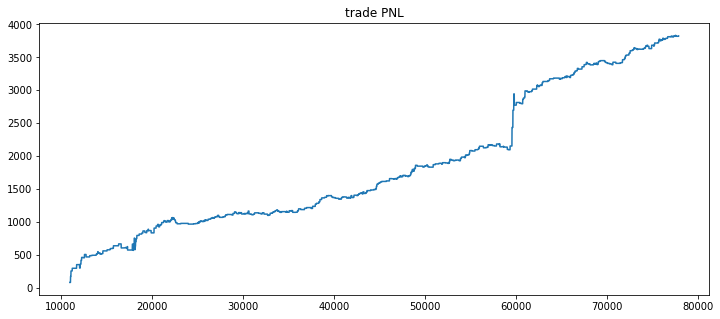

In [37]:
initDF = trades[0]
for tr in trades[1:]:
    initDF = initDF.append(tr, ignore_index=True)


SLIPPADGE = 2
ret = pd.DataFrame(initDF)
ret['profit'] = (ret["position"] * (ret["closePrice"] - ret["openPrice"]) - SLIPPADGE if (ret["typeOperation"] == 'BUY').bool else abs(ret["position"]) * (ret["openPrice"] - ret["closePrice"]) - SLIPPADGE)
ret.index = ret.openIndex
stepDF = pd.DataFrame(index=pd.RangeIndex(min(ret.openIndex), max(ret.openIndex)))
stepPnl = stepDF.merge(ret, left_index=True, right_index=True, how='outer').profit.replace(np.nan, 0).cumsum()
del stepDF
TPNL = stepPnl.iloc[-1]
print('TOTAL PNL = ', TPNL)
PNLDD = TPNL / calculate_max_drawdown(stepPnl)
print('DD DIV TOTAL PNL = ', PNLDD)
plt.figure(figsize=(12,5))
plt.plot(stepPnl)
plt.title('trade PNL')
plt.show()
